In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

In [2]:
# Download the dataset if it hasn't already been downloaded.
from pathlib import Path
if not Path("hurricane").exists():
  print("Downloading dataset...")
  !wget https://pat-laub.github.io/DeepLearningMaterials/2023/Lecture-4-Computer-Vision/hurricane.zip
  !unzip hurricane.zip
else:
  print("Already downloaded.")

Streaming output truncated to the last 5000 lines.
  inflating: hurricane/no_damage/-95.290402_29.608634000000002.jpeg  
  inflating: hurricane/no_damage/-95.290477_29.607621999999996.jpeg  
  inflating: hurricane/no_damage/-95.290595_29.607621999999996.jpeg  
  inflating: hurricane/no_damage/-95.290627_29.400714.jpeg  
  inflating: hurricane/no_damage/-95.290646_29.608632.jpeg  
  inflating: hurricane/no_damage/-95.290729_29.607621999999996.jpeg  
  inflating: hurricane/no_damage/-95.29079899999999_29.402665999999996.jpeg  
  inflating: hurricane/no_damage/-95.291042_29.402655.jpeg  
  inflating: hurricane/no_damage/-95.291228_29.402317.jpeg  
  inflating: hurricane/no_damage/-95.291363_29.400990000000004.jpeg  
  inflating: hurricane/no_damage/-95.29164499999999_29.595205.jpeg  
  inflating: hurricane/no_damage/-95.29172700000001_29.402413.jpeg  
  inflating: hurricane/no_damage/-95.292333_29.401585999999998.jpeg  
  inflating: hurricane/no_damage/-95.29348_29.593476000000003.jpeg  


In [3]:
!pip install directory_tree

from directory_tree import display_tree
display_tree("hurricane")

Streaming output truncated to the last 5000 lines.
    ├── -95.290477_29.607621999999996.jpeg
    ├── -95.2904_29.608598999999998.jpeg
    ├── -95.290595_29.607621999999996.jpeg
    ├── -95.290627_29.400714.jpeg
    ├── -95.290646_29.608632.jpeg
    ├── -95.290729_29.607621999999996.jpeg
    ├── -95.29079899999999_29.402665999999996.jpeg
    ├── -95.291042_29.402655.jpeg
    ├── -95.291228_29.402317.jpeg
    ├── -95.291363_29.400990000000004.jpeg
    ├── -95.29164499999999_29.595205.jpeg
    ├── -95.29172700000001_29.402413.jpeg
    ├── -95.292333_29.401585999999998.jpeg
    ├── -95.29348_29.593476000000003.jpeg
    ├── -95.293848_29.598968.jpeg
    ├── -95.293892_29.462031.jpeg
    ├── -95.293921_29.462253000000004.jpeg
    ├── -95.294025_29.462993.jpeg
    ├── -95.294034_29.598758.jpeg
    ├── -95.294048_29.462803000000005.jpeg
    ├── -95.294093_29.463841.jpeg
    ├── -95.294134_29.463093.jpeg
    ├── -95.294211_29.462909000000003.jpeg
    ├── -95.294251_29.463157.jpeg
    ├── -95.2

In [4]:
!pip install split-folders

import splitfolders
splitfolders.ratio("hurricane", output="hurricane-split",
    seed=1234, ratio=(1/2, 1/4, 1/4))

display_tree("hurricane-split", max_depth=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 21492 files [00:02, 8152.30 files/s] 

hurricane-split/
├── test/
├── train/
└── val/


In [5]:
display_tree("hurricane-split")

Streaming output truncated to the last 5000 lines.
    │   ├── -93.98114_29.897457.jpeg
    │   ├── -93.98114_29.898584999999997.jpeg
    │   ├── -93.98119399999999_30.130602000000003.jpeg
    │   ├── -93.981288_30.151077.jpeg
    │   ├── -93.981339_30.149887.jpeg
    │   ├── -93.981639_29.895409.jpeg
    │   ├── -93.98179499999999_30.150342.jpeg
    │   ├── -93.98201999999999_29.899831.jpeg
    │   ├── -93.98218100000001_29.899328999999998.jpeg
    │   ├── -93.982277_30.148871000000003.jpeg
    │   ├── -93.982299_30.137856.jpeg
    │   ├── -93.982525_29.899576.jpeg
    │   ├── -93.98268_30.146203999999997.jpeg
    │   ├── -93.982776_30.148629999999997.jpeg
    │   ├── -93.982792_30.147614.jpeg
    │   ├── -93.982867_30.148035999999998.jpeg
    │   ├── -93.98291_29.900447999999997.jpeg
    │   ├── -93.984702_29.894140999999998.jpeg
    │   ├── -93.985126_29.893246.jpeg
    │   ├── -93.985281_29.893337.jpeg
    │   ├── -93.985405_29.89343.jpeg
    │   ├── -93.985791_29.893683000000003.j

In [6]:
from tensorflow.keras.utils import\
  image_dataset_from_directory

data_dir = "hurricane-split"
batch_size = 16 # Edit depending on size of the training, validation, and test sets due to epochs functioning in the GPU
img_height = 80
img_width = 80
img_size = (img_height, img_width)

In [7]:
train_ds = image_dataset_from_directory(
    data_dir + "/train",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

Found 10746 files belonging to 2 classes.


In [8]:
val_ds = image_dataset_from_directory(
    data_dir + "/val",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

Found 5373 files belonging to 2 classes.


In [9]:
test_ds = image_dataset_from_directory(
    data_dir + "/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

Found 5373 files belonging to 2 classes.


In [10]:
# NB: Need shuffle=False earlier for these X & y to line up.

X_train = np.concatenate(list(train_ds.map(lambda x, y: x)))
y_train = np.concatenate(list(train_ds.map(lambda x, y: y)))

X_val = np.concatenate(list(val_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))

X_test = np.concatenate(list(test_ds.map(lambda x, y: x)))
y_test = np.concatenate(list(test_ds.map(lambda x, y: y)))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10746, 80, 80, 1),
 (10746,),
 (5373, 80, 80, 1),
 (5373,),
 (5373, 80, 80, 1),
 (5373,))

Essentially, we are looking at 10,746 pictures of 128x128 pixel size for 1 channel (TRAINING DATA), and 5,373 pictures of 128x128 pixel size for 1 channel (VALIDATION AND TEST DATA)



In [11]:
# Making the CNN

from tensorflow.keras.layers \
  import Rescaling, Conv2D, MaxPooling2D, Flatten

numClasses = np.unique(y_train).shape[0]
random.seed(1234)

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 1)), #Here, we grab every image we throw at it and it will divide by 255, with our dimensions given
  Conv2D(16, 5, padding="same", activation="relu", name="conv1"), #Using zero padding (input same size as the output)
  MaxPooling2D(name="pool1"),
  Conv2D(32, 5, padding="same", activation="relu", name="conv2"),
  MaxPooling2D(name="pool2"),
  Conv2D(64, 5, padding="same", activation="relu", name="conv3"),
  MaxPooling2D(name="pool3"),
  Conv2D(128, 5, padding="same", activation="relu", name="conv4"),
  MaxPooling2D(name="pool4"),
  Flatten(), Dense(258, activation="relu"), Dense(numClasses)
  ])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 16)        416       
                                                                 
 pool1 (MaxPooling2D)        (None, 40, 40, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 32)        12832     
                                                                 
 pool2 (MaxPooling2D)        (None, 20, 20, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 20, 20, 64)        51264     
                                                                 
 pool3 (MaxPooling2D)        (None, 10, 10, 64)        0

The process of halving the height and weight in the pooling continues until we flatten down the data - As a result, we just grab all before and stick them into a single vector. We are compressing 32,786 neuron values into 256.

In [13]:
# Fitting the CNN

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Essentially fitting the softmax into the loss function
topk = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy', topk]) # 'topk' accuracy looks at the largest 5 probabilities that the network thinks the different categories are and was the true category one of these top 5

epochs = 100
es = EarlyStopping(patience=15, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)

hist = model.fit(train_ds.shuffle(10000), validation_data=val_ds,
  epochs=epochs, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


In [14]:
def plot_history(hist):
    epochs = range(len(hist.history["loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.history["accuracy"], label="Train")
    plt.plot(epochs, hist.history["val_accuracy"], label="Val")
    plt.legend(loc="lower right")
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.history["loss"], label="Train")
    plt.plot(epochs, hist.history["val_loss"], label="Val")
    plt.legend(loc="upper right")
    plt.title("Loss")

    plt.show()

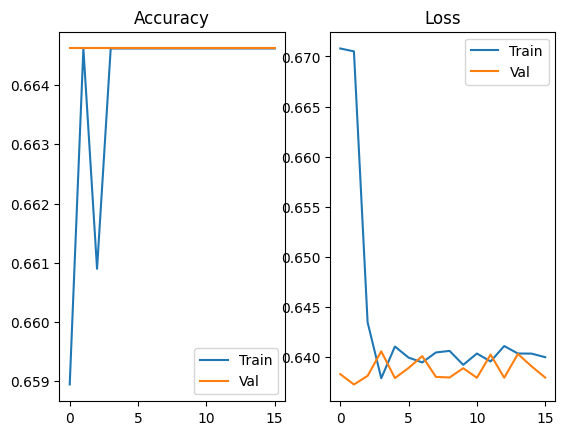

In [15]:
plot_history(hist)

In [16]:
print(model.evaluate(train_ds, verbose=0))
print(model.evaluate(val_ds, verbose=0))
print(model.evaluate(test_ds, verbose=0))

[0.6382918357849121, 0.6646193861961365, 1.0]
[0.6383182406425476, 0.6646193861961365, 1.0]
[0.6382566690444946, 0.6646193861961365, 1.0]


In [17]:
X_test[21].shape, X_test[21][np.newaxis, :].shape, X_test[[21]].shape

((80, 80, 1), (1, 80, 80, 1), (1, 80, 80, 1))

In [18]:
model.predict(X_test[[21]], verbose=0)

array([[ 0.36923957, -0.40355206]], dtype=float32)

In [19]:
model.predict(X_test[[21]], verbose=0).argmax()

0

In [20]:
test_ds.class_names[model.predict(X_test[[21]], verbose=0).argmax()]

'damage'

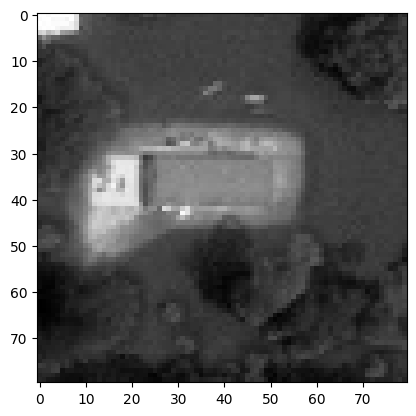

In [21]:
plt.imshow(X_test[21], cmap="gray");

In [22]:
!pip install keras-tuner

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(
        Dense(
            hp.Choice("neurons", [8, 16, 32, 64, 128, 256, 512]),
            activation=hp.Choice("activation",
                ["relu", "leaky_relu", "tanh"]),
        )
    )

    model.add(Dense(1, activation="exponential"))

    learning_rate = hp.Float("lr",
        min_value=1e-4, max_value=1e-2, sampling="log")
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss="poisson")

    return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.9 MB/s eta 0:00:00


In [23]:
tuner = kt.RandomSearch(
  build_model,
  objective="val_loss",
  max_trials=10,
  directory="random-search")

es = EarlyStopping(patience=3,
  restore_best_weights=True)

tuner.search(X_train, y_train,
  epochs=100, callbacks = [es],
  validation_data=(X_val, y_val))

best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 01m 24s]
val_loss: 0.7020692229270935

Best val_loss So Far: 0.7008321285247803
Total elapsed time: 00h 09m 04s


In [24]:
tuner.results_summary(1)

Results summary
Results in random-search/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
neurons: 16
activation: tanh
lr: 0.00287149017681153
Score: 0.7008321285247803
